# **Predicting Car Prices**

# 1. Introduction

Discount Motors will soon be losing its car-pricing expert to retirement. The sales team would like to know if car pricing can be automated, ideally such that predicted prices are within 10% of actual prices. An automated system would benefit the organization in terms of efficiency and sales. Currently, manual estimates made by the team are about 30% off.

Therefore, the goals of this analysis were to train and evaluate predictive models, then make recommendations for steps forward. This technical report includes code, code output, and written summaries organized in the following sections: 2. Data Validation, 3. Exploratory Analysis, 4. Model Development, 5. Model Evaluation, 6. Key Performance Indicator, and 7. Summary and Recommendations.

In [1]:
# import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# set pandas display precision to 3 places after decimal
pd.set_option('display.precision', 3)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
filename = 'toyota.csv'
data = pd.read_csv(filename)

In [3]:
# preview data
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [4]:
# number of rows and columns
data.shape

(6738, 9)

In [5]:
# check for duplicate rows based on all columns
data.duplicated().sum()

39

In [6]:
# create filter to display duplicate rows including first occurrence
duplicated = data.duplicated(keep=False)

# display duplicate rows including first occurrences
display(data[duplicated])

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
177,Corolla,2019,17960,Manual,4500,Petrol,145,39.2,1.2
178,Corolla,2019,17960,Manual,4500,Petrol,145,39.2,1.2
285,Corolla,2019,15991,Manual,10,Petrol,145,39.2,1.2
286,Corolla,2019,15991,Manual,10,Petrol,145,39.2,1.2
344,RAV4,2015,13500,Manual,45757,Diesel,125,57.6,2.0
...,...,...,...,...,...,...,...,...,...
5560,Aygo,2019,10750,Manual,32,Petrol,145,57.7,1.0
6356,Avensis,2017,10595,Manual,35939,Diesel,145,67.3,1.6
6357,Avensis,2017,10595,Manual,35939,Diesel,145,67.3,1.6
6569,Hilux,2015,14995,Automatic,72100,Diesel,260,32.8,3.0


In [7]:
# drop 39 duplicate rows from dataset, keeping the first occurrences
data = data.drop_duplicates(keep='first')

# original number of rows was 6738. now, it should be 6699
data.shape

(6699, 9)

In [8]:
# check column data types and number of non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6699 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6699 non-null   object 
 1   year          6699 non-null   int64  
 2   price         6699 non-null   int64  
 3   transmission  6699 non-null   object 
 4   mileage       6699 non-null   int64  
 5   fuelType      6699 non-null   object 
 6   tax           6699 non-null   int64  
 7   mpg           6699 non-null   float64
 8   engineSize    6699 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 523.4+ KB


In [9]:
# check numeric column descriptive statistics
display(data.describe())

,year,price,mileage,tax,mpg,engineSize
count,6699.000,6699.000,6699.000,6699.000,6699.000,6699.000
mean,2016.743,12529.799,22889.589,94.550,63.079,1.472
std,2.205,6358.563,19109.289,73.943,15.861,0.436
min,1998.000,850.000,2.000,0.000,2.800,0.000
25%,2016.000,8266.500,9488.500,0.000,55.400,1.000
50%,2017.000,10798.000,18571.000,135.000,62.800,1.500
75%,2018.000,14995.000,31059.500,145.000,70.600,1.800
max,2020.000,59995.000,174419.000,565.000,235.000,4.500


In [10]:
# range of years appears appropriate

# lowest price appears appropriate.
# investigate highest prices
data.sort_values(by='price', ascending=False).head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6711,Supra,2019,59995,Automatic,9909,Other,150,34.5,3.0
6670,Land Cruiser,2019,54991,Semi-Auto,1000,Diesel,145,30.1,2.8
6695,Land Cruiser,2020,54550,Automatic,4000,Diesel,150,30.1,2.8
6688,Land Cruiser,2020,52990,Automatic,1244,Diesel,145,30.1,2.8
6672,Land Cruiser,2020,52291,Semi-Auto,3104,Diesel,145,30.1,2.8


In [11]:
# highest prices appear appropriate.

# highest mileage appears appropriate.
# investigate lowest mileages
data.sort_values(by='mileage', ascending=True).head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
1630,Yaris,2020,14990,Automatic,2,Petrol,150,47.9,1.5
6264,Prius,2020,25990,Automatic,3,Hybrid,135,64.2,1.8
5193,Aygo,2019,10995,Manual,3,Petrol,145,57.7,1.0
5211,Aygo,2019,9391,Manual,3,Petrol,145,56.5,1.0
6583,Hilux,2019,26995,Automatic,4,Diesel,265,2.8,2.4
6684,Land Cruiser,2020,47885,Automatic,4,Diesel,145,30.1,2.8
1397,Yaris,2019,11888,Manual,4,Petrol,145,47.9,1.5
4032,Aygo,2019,10495,Manual,4,Petrol,145,57.7,1.0
4229,Aygo,2019,9295,Manual,5,Petrol,145,56.5,1.0
6634,PROACE VERSO,2019,27998,Automatic,5,Diesel,145,38.7,2.0


In [12]:
# lowest mileages are associated with young cars
# this seems plausible

# highest tax appears appropriate.
# investigate tax=0
display((data['tax']==0).sum())
data[data['tax']==0].sort_values(by='mpg', ascending=True).head()

1787

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6732,IQ,2012,2495,Manual,72498,Petrol,0,64.2,1.0
6730,IQ,2013,4849,Manual,41142,Petrol,0,64.2,1.0
5054,Aygo,2014,4495,Manual,35863,Petrol,0,65.7,1.0
5355,Aygo,2012,3950,Manual,55000,Petrol,0,65.7,1.0
4992,Aygo,2013,4695,Manual,20000,Petrol,0,65.7,1.0


In [13]:
# tax=0 is associated with high-mpg cars.
# this seems plausible (zero-tax incentives for high-efficiency vehicles)

# investigate lowest mpgs
data.sort_values(by='mpg', ascending=True).head(20)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6594,Hilux,2020,39257,Automatic,1259,Diesel,265,2.8,2.4
6583,Hilux,2019,26995,Automatic,4,Diesel,265,2.8,2.4
6575,Hilux,2019,26500,Automatic,7123,Diesel,260,2.8,2.4
6562,Hilux,2020,18495,Manual,50,Diesel,260,2.8,2.4
6595,Hilux,2019,27850,Automatic,10250,Diesel,260,2.8,2.4
6596,Hilux,2020,30500,Automatic,5000,Diesel,260,2.8,2.4
6552,Hilux,2019,28495,Automatic,3350,Diesel,260,2.8,2.4
6576,Hilux,2019,20500,Manual,5190,Diesel,260,2.8,2.4
6617,Hilux,2020,36995,Automatic,150,Diesel,260,2.8,2.4
6563,Hilux,2020,23495,Manual,100,Diesel,260,2.8,2.4


In [14]:
# rows with mpg < 10 are not plausible (I looked up mpg of 2019/2020 Hilux and 2018 CH-R)
# need to replace these mpg values with null.
data.loc[data['mpg'] < 10, 'mpg'] = np.nan

# confirm change
data.sort_values(by='mpg', ascending=True).head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6694,Land Cruiser,1998,19990,Manual,100000,Diesel,265,23.9,4.2
6693,Land Cruiser,2004,6450,Automatic,143000,Diesel,325,27.2,3.0
6698,Land Cruiser,2014,44990,Automatic,60000,Diesel,540,29.7,4.5
6687,Land Cruiser,2020,45950,Automatic,27,Diesel,145,30.1,2.8
6667,Land Cruiser,2019,50995,Semi-Auto,6254,Diesel,145,30.1,2.8


In [15]:
# investigate highest mpgs
data.sort_values(by='mpg', ascending=False).head(50)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6207,Prius,2019,22495,Automatic,13772,Hybrid,135,235.0,1.8
6124,Prius,2020,27990,Automatic,1500,Hybrid,135,235.0,1.8
6267,Prius,2018,19699,Automatic,43678,Hybrid,135,235.0,1.8
6098,Prius,2017,20795,Automatic,3881,Hybrid,135,235.0,1.8
6103,Prius,2018,20495,Automatic,16347,Hybrid,140,235.0,1.8
6236,Prius,2019,21500,Automatic,4000,Hybrid,135,235.0,1.8
6256,Prius,2018,18150,Automatic,59191,Other,135,235.0,1.8
6116,Prius,2017,19998,Automatic,13476,Hybrid,140,235.0,1.8
6118,Prius,2019,24987,Automatic,6552,Hybrid,135,235.0,1.8
6223,Prius,2018,18699,Automatic,34502,Hybrid,140,235.0,1.8


In [16]:
# based on my research, these mpg values appear to be lab-derived (i.e., NEDC- and WLTP-reported values).
# therefore, the high values are plausible.

# highest engine size appears appropriate.
# investigate lowest engine sizes
data.sort_values(by='engineSize', ascending=True).head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
5233,Aygo,2019,8000,Manual,8531,Petrol,145,56.5,0.0
5960,C-HR,2017,14300,Manual,46571,Petrol,145,47.1,0.0
5257,Aygo,2019,8000,Manual,5354,Petrol,145,56.5,0.0
2545,Yaris,2016,11000,Automatic,39909,Hybrid,0,86.0,0.0
5126,Aygo,2019,9800,Manual,3635,Petrol,150,56.5,0.0
2535,Yaris,2016,12300,Manual,6148,Hybrid,0,86.0,0.0
3984,Aygo,2018,9295,Manual,11000,Petrol,150,56.5,1.0
3960,Aygo,2017,7480,Manual,22744,Petrol,0,69.0,1.0
3961,Aygo,2015,5498,Manual,33248,Petrol,0,69.0,1.0
3962,Aygo,2018,9488,Semi-Auto,15212,Petrol,150,67.3,1.0


In [17]:
# these hybrid and petrol vehicles cannot have 0.0 L engine sizes.
# need to replace these 0 values with null.
data.loc[data['engineSize'] == 0, 'engineSize'] = np.nan

# confirm change
data.sort_values(by='engineSize', ascending=True).head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
5261,Aygo,2018,7300,Manual,14521,Petrol,145,69.0,1.0
3960,Aygo,2017,7480,Manual,22744,Petrol,0,69.0,1.0
3961,Aygo,2015,5498,Manual,33248,Petrol,0,69.0,1.0
3962,Aygo,2018,9488,Semi-Auto,15212,Petrol,150,67.3,1.0
3963,Aygo,2019,7890,Manual,8441,Petrol,145,56.5,1.0
3964,Aygo,2019,8790,Manual,12143,Petrol,145,57.7,1.0
3965,Aygo,2017,6490,Manual,10967,Petrol,0,69.0,1.0
3966,Aygo,2015,5995,Manual,26200,Petrol,0,69.0,1.0
3967,Aygo,2019,8788,Manual,3305,Petrol,150,56.5,1.0
3968,Aygo,2016,7000,Manual,14347,Petrol,0,69.0,1.0


In [18]:
# get unique values: 'model'
display(data['model'].value_counts())
print('Number of unique values: {}'.format(data['model'].nunique()))

model
Yaris            2117
Aygo             1940
Auris             709
C-HR              479
RAV4              467
Corolla           265
Prius             232
Verso             114
Avensis           114
Hilux              85
GT86               73
Land Cruiser       51
PROACE VERSO       15
Supra              12
Camry              11
IQ                  8
Urban Cruiser       4
Verso-S             3
Name: count, dtype: int64

Number of unique values: 18


In [19]:
# get unique values: 'transmission'
display(data['transmission'].value_counts())
print('Number of unique values: {}'.format(data['transmission'].nunique()))

transmission
Manual       3793
Automatic    2651
Semi-Auto     254
Other           1
Name: count, dtype: int64

Number of unique values: 4


In [20]:
# get unique values: 'fuelType'
display(data['fuelType'].value_counts())
print('Number of unique values: {}'.format(data['fuelType'].nunique()))

fuelType
Petrol    4058
Hybrid    2040
Diesel     496
Other      105
Name: count, dtype: int64

Number of unique values: 4


In [21]:
# get unique values: 'engineSize'
display(data['engineSize'].value_counts())
print('Number of unique values: {}'.format(data['engineSize'].nunique()))

engineSize
1.0    2038
1.5    1419
1.8    1289
1.3     600
2.0     394
1.2     300
2.5     247
1.6     166
2.4      70
2.2      58
1.4      40
2.8      36
3.0      34
4.2       1
4.5       1
Name: count, dtype: int64

Number of unique values: 15


In [22]:
# display number of rows and columns
data.shape

(6699, 9)

In [23]:
# display number of null values per column
print(data.isna().sum())

model            0
year             0
price            0
transmission     0
mileage          0
fuelType         0
tax              0
mpg             11
engineSize       6
dtype: int64


In [24]:
# number of rows with null value in any column
print(data.isna().any(axis=1).sum())

17


# 2. Data Validation

The dataset provided by the sales team contains used car characteristics and final sales prices from the past 6 months. Validation was performed to understand the dataset's dimensions, identify any duplicate rows, identify any null values, identify any abnormal values, and ensure each column matches its corresponding description in the data dictionary.

Overall, the original dataset comprised 6738 rows and 9 columns, 39 duplicate rows, and no null values. The 39 duplicate rows were removed (with first occurrences retained) because it is very unlikely that there were cars that had identical attribute values across all columns (especially 'mileage'). These rows were likely to have been erroneously duplicated. It is important to remove them from the perspective of model evaluation. If duplicate rows are retained, they can end up being part of both the training data and the test data. This can lead to an optimistically biased estimate of model performance on unseen data.

During range validation, abnormal values were found for 'mpg' and 'engineSize'. There were 11 cars with mpg values under 10. Based on research, these mpg values should be higher, so they were marked as null. Also, six cars had engine sizes of 0.0 L. Based on research, these engine sizes should be higher, so they were marked as null.

The following list summarizes the inspection and resulting data cleaning of each column:

- **model**:
  - Correct data type (object/character)
  - 18 unique values as described in data dictionary
  - No cleaning needed
- **year**:
  - Correct data type (integer/numeric)
  - Values range from 1998-2020 as described in data dictionary
  - No cleaning needed
- **price**:
  - Correct data type (integer/numeric)
  - Minimum and maximum values appear appropriate
  - No cleaning needed
- **transmission**:
  - Correct data type (object/character)
  - 4 unique values as described in data dictionary ('Manual', 'Automatic', 'Semi-Auto', 'Other')
  - No cleaning needed
- **mileage**:
  - Correct data type (integer/numeric)
  - Minimum and maximum values appear appropriate
  - No cleaning needed
- **fuelType**:
  - Correct data type (object/character)
  - 4 unique values as described in data dictionary ('Petrol', 'Hybrid', 'Diesel', 'Other')
  - No cleaning needed
- **tax**:
  - Correct data type (integer/numeric)
  - Minimum and maximum values appear appropriate
  - No cleaning needed
- **mpg**:
  - Correct data type (float/numeric)
  - Maximum value appears appropriate
  - There were 11 values under 10. Based on research, they were deemed inaccurate and changed to null.
- **engineSize**:
  - Correct data type (float/numeric)
  - 16 unique values as described in data dictionary
  - Maximum value appears appropriate
  - There were 6 values of 0. Based on research, they were deemed inaccurate and changed to null.
 
The cleaned dataset comprised 6699 rows and 9 columns, 0 duplicate rows, and 17 rows with null values.

# 3. Exploratory Analysis

Exploratory analysis of the cleaned dataset was performed to understand the distribution and descriptive statistics of each variable as well as the relationships between numeric variables. The analysis is organized in the following subsections: 3.1 Numeric Variables, 3.2 Categorical Variables, and 3.3 Numeric Variable Relationships.

## 3.2 Numeric Variables

Table 1 and Figure 1 show descriptive statistics and a multivariate boxplot of the numeric variables, respectively. The target variable, price, has a median of 10798 GBP. In other words, half of the cars in the database sold for this price or lower. Moreover, 75% of cars sold for 14995 GBP or less. The data are right-skewed with exterme values marked by circles, showing that some cars sold for as much as 59995 GBP (Figure 1).

Table 1: Descriptive statistics for numeric variables.

In [25]:
# generate numeric column descriptive statistics table
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6699.000,6699.000,6699.000,6699.000,6688.000,6693.000
mean,2016.743,12529.799,22889.589,94.550,63.177,1.473
std,2.205,6358.563,19109.289,73.943,15.686,0.434
min,1998.000,850.000,2.000,0.000,23.900,1.000
25%,2016.000,8266.500,9488.500,0.000,55.400,1.000
50%,2017.000,10798.000,18571.000,135.000,62.800,1.500
75%,2018.000,14995.000,31059.500,145.000,70.600,1.800
max,2020.000,59995.000,174419.000,565.000,235.000,4.500


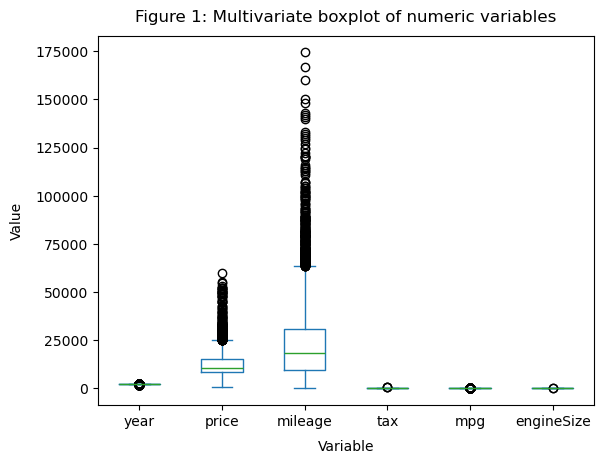

In [26]:
# generate boxplot: numeric columns
data.plot(kind='box')
plt.title('Figure 1: Multivariate boxplot of numeric variables', pad=10.0)
plt.xlabel('Variable', labelpad=8.0)
plt.ylabel('Value', labelpad=8.0)
plt.show()

Table 1 and Figure 1 also show that the numeric variables have different value ranges. To examine their distributions in greater detail, Figures 2-7 display histograms for each variable. Most variables (Figures 3-7) have right-skewed distributions, while 'year' is left-skewed (Figure 2).

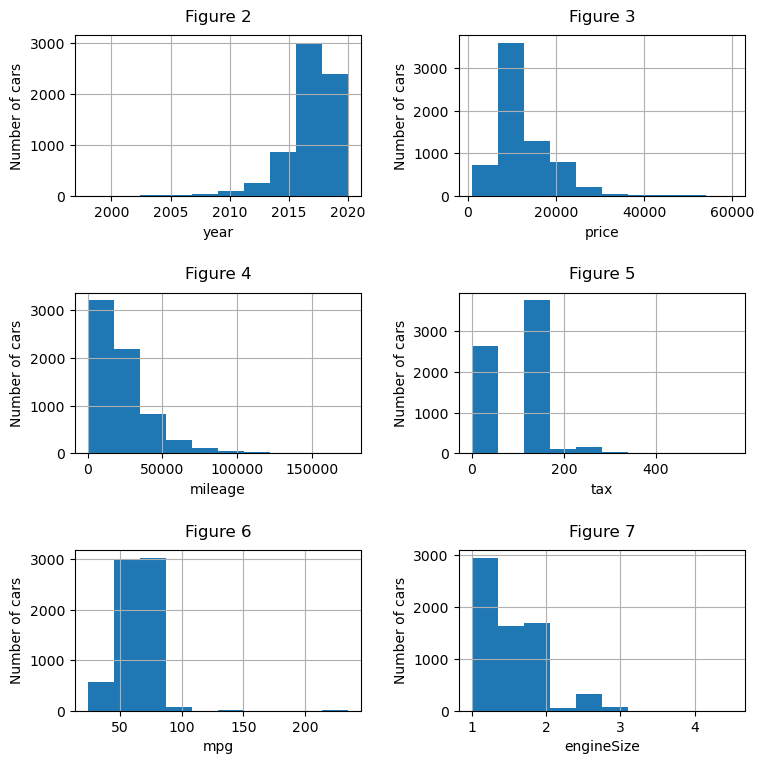

In [27]:
# set up figure with subplots
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

# generate histogram: year
data['year'].hist(ax=ax[0,0])
ax[0,0].set_title('Figure 2', pad=10.0)
ax[0,0].set_xlabel('year', labelpad=4.0)
ax[0,0].set_ylabel('Number of cars', labelpad=4.0)

# generate histogram: price
data['price'].hist(ax=ax[0,1], xrot=0)
ax[0,1].set_title('Figure 3', pad=10.0)
ax[0,1].set_xlabel('price', labelpad=4.0)
ax[0,1].set_ylabel('Number of cars', labelpad=4.0)

# generate histogram: mileage
data['mileage'].hist(ax=ax[1,0], xrot=0)
ax[1,0].set_title('Figure 4', pad=10.0)
ax[1,0].set_xlabel('mileage', labelpad=4.0)
ax[1,0].set_ylabel('Number of cars', labelpad=4.0)

# generate histogram: tax
data['tax'].hist(ax=ax[1,1])
ax[1,1].set_title('Figure 5', pad=10.0)
ax[1,1].set_xlabel('tax', labelpad=4.0)
ax[1,1].set_ylabel('Number of cars', labelpad=4.0)

# generate histogram: mpg
data['mpg'].hist(ax=ax[2,0])
ax[2,0].set_title('Figure 6', pad=10.0)
ax[2,0].set_xlabel('mpg', labelpad=4.0)
ax[2,0].set_ylabel('Number of cars', labelpad=4.0)

# generate histogram: engineSize
data['engineSize'].hist(ax=ax[2,1])
ax[2,1].set_title('Figure 7', pad=10.0)
ax[2,1].set_xlabel('engineSize', labelpad=4.0)
ax[2,1].set_ylabel('Number of cars', labelpad=4.0)

# adjust subplot spacing
fig.tight_layout(pad=2.0)

# display subplots
plt.show()

Due to the differing scales of the numeric variables, each numeric predictor variable will be normalized, i.e., rescaled to a range of 0 to 1. This preprocessing technique is important because some machine learning algorithms (e.g., linear regression, k-nearest neighbors, support vector machine) perform better when numeric variables are on same scale.

## 3.2 Categorical Variables

The categorical variables were examined to explore the proportion of cars in each category. Figures 8, 9, and 10 shows the proportion of cars in the database for each model, transmission type, and fuel type, respectively. Yaris is the most popular model (32%), followed closely by Aygo (29%) (Figure 8). The majority (57%) of cars have manual transmissions, although a large percentage have automatic transmissions (40%) (Figure 9). Most cars have petrol fuel types (61%), followed by hybrid (30%), diesel (7%), and other (2%) (Figure 10).

In [28]:
# display proportion of cars by model, transmission, and fuelType
display(data['model'].value_counts(normalize=True).round(2))
display(data['transmission'].value_counts(normalize=True).round(2))
display(data['fuelType'].value_counts(normalize=True).round(2))

model
Yaris            0.32
Aygo             0.29
Auris            0.11
C-HR             0.07
RAV4             0.07
Corolla          0.04
Prius            0.03
Verso            0.02
Avensis          0.02
Hilux            0.01
GT86             0.01
Land Cruiser     0.01
PROACE VERSO     0.00
Supra            0.00
Camry            0.00
IQ               0.00
Urban Cruiser    0.00
Verso-S          0.00
Name: proportion, dtype: float64

transmission
Manual       0.57
Automatic    0.40
Semi-Auto    0.04
Other        0.00
Name: proportion, dtype: float64

fuelType
Petrol    0.61
Hybrid    0.30
Diesel    0.07
Other     0.02
Name: proportion, dtype: float64

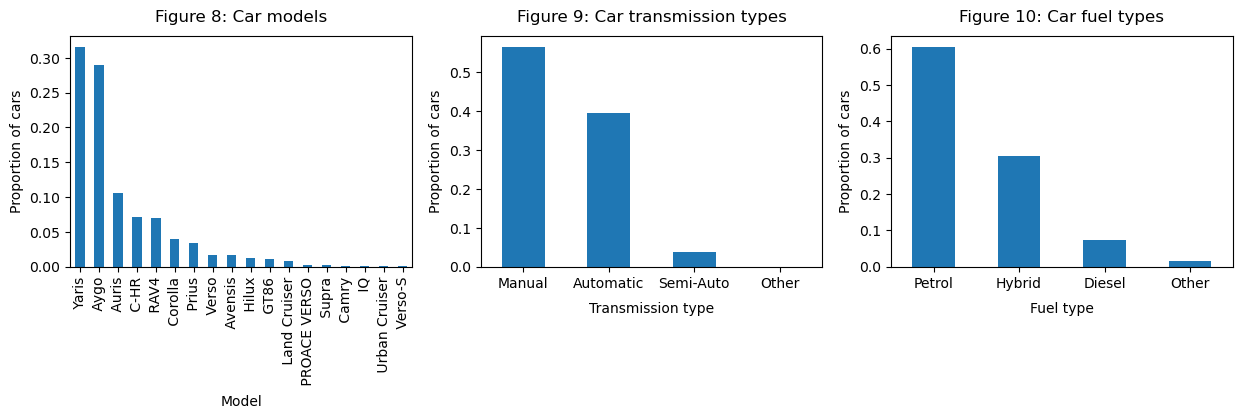

In [29]:
# set up figure with subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

# generate bar plot: model
data['model'].value_counts(normalize=True).plot(kind='bar', rot=90, ax=ax[0])
ax[0].set_title('Figure 8: Car models', pad=10.0)
ax[0].set_xlabel('Model', labelpad=4.0)
ax[0].set_ylabel('Proportion of cars', labelpad=4.0)

# generate bar plot: transmission
data['transmission'].value_counts(normalize=True).plot(kind='bar', rot=0, ax=ax[1])
ax[1].set_title('Figure 9: Car transmission types', pad=10.0)
ax[1].set_xlabel('Transmission type', labelpad=8.0)
ax[1].set_ylabel('Proportion of cars', labelpad=4.0)

# generate bar plot: fuelType
data['fuelType'].value_counts(normalize=True).plot(kind='bar', rot=0, ax=ax[2])
ax[2].set_title('Figure 10: Car fuel types', pad=10.0)
ax[2].set_xlabel('Fuel type', labelpad=8.0)
ax[2].set_ylabel('Proportion of cars', labelpad=4.0)

# display subplots
plt.show()

Because machine learning models generally require all variables to be numeric, the categorical variables will be one-hot encoded. One-hot encoding will create a binary variable for each category and remove the original categorical variables.

## 3.3 Numeric Variable Relationships

To examine the relationships between the numeric variables, the Kendall Tau correlation coefficient was calculated for each pair (Figure 11). This coefficient was used due to the non-normal data distributions (Figures 2-7). In terms of predictor-target pairs, there is a strong positive relationship (0.60) between 'engineSize' and 'price'; cars with larger engines tend to cost more. A weaker positive relationship (0.33) exists between 'year' and 'price', with newer cars having higher prices (Figure 11). In terms of predictor-predictor pairs, there is a strong negative relationship (-0.59) between 'year' and 'mileage', with newer cars having a lower mileage. A moderate negative relationship (-0.48) exists between 'mpg' and 'tax', with higher miles-per-gallon cars having lower taxes.

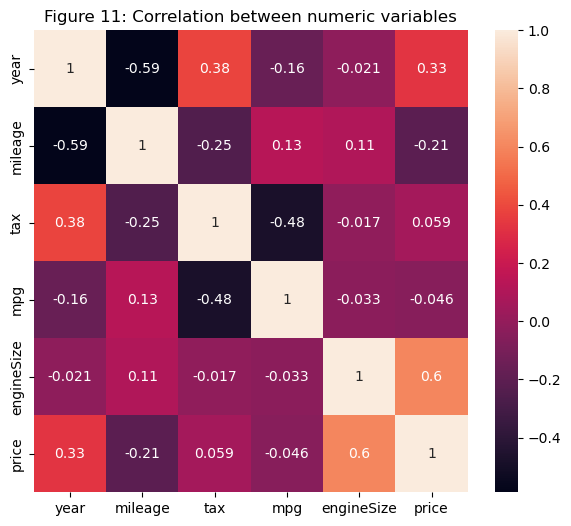

In [30]:
# generate correlation matrix: numeric columns
fig = plt.figure(figsize=(7, 6))
sns.heatmap(data=data[['year', 'mileage', 'tax', 'mpg','engineSize','price']].corr(method='kendall'), annot=True)
plt.title('Figure 11: Correlation between numeric variables')
plt.show()

# 4. Model Development

## 4.1 Type of Problem

To recap, the business goal is to predict car prices. Because we have labeled data, this is a supervised machine learning task. Furthermore, because the target variable ('price') is continuous, this is a regression problem.

## 4.2 Data Preprocessing

Before modeling, the data had to be preprocessed. First, the dataset was split into a feature set of predictor variables and a target set of the target variable 'price'. The feature set and target set were then split into train and test sets. Data splitting was performed such that 80% and 20% of the rows were assigned to the train and test sets, respectively. The train sets were used for model training and tuning, while the test sets were used for final model evaluation.

In [31]:
# split data into X (features) and y (target)
X = data.drop('price', axis=1)
y = data[['price']]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.20, random_state=1)

# confirm 80%/20% train/test splits
print(f'Dimensions:\nX_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')

Dimensions:
X_train: (5359, 8)
X_test: (1340, 8)
y_train: (5359, 1)
y_test: (1340, 1)


Following data splitting, the predictor variables (features) were transformed. Since the numeric and categorical features required different transforms, ColumnTransformer was used to apply the appropriate transform(s) to each feature. Missing values in the numeric features ('year', 'mileage', 'tax', 'mpg','engineSize') were first imputed using SimpleImputer. The median was used since this is the appropriate statistic for non-normally distributed variables. Then, the numeric features were scaled to a range of 0 to 1 using MinMaxScaler. The categorical features ('model', 'transmission', 'fuelType') were one-hot encoded using OneHotEncoder. Data leakage did not occur since the scaling and one-hot encoding transforms were fit using the training feature set only.

In [32]:
# create list of transforms to apply (SimpleImputer, MinMaxScaler to numeric features and OneHotEncoder to categorical features)
transformers = [
    ('i_s', make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0,1))), ['year', 'mileage', 'tax', 'mpg','engineSize']),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['model', 'transmission', 'fuelType'])
]

# instantiate a ColumnTransformer object with list of transforms
col_transformer = ColumnTransformer(transformers=transformers, verbose_feature_names_out=False)

# fit column transformer to training features and transform them
X_train_transformed = col_transformer.fit_transform(X_train)

# transform testing features
X_test_transformed = col_transformer.transform(X_test)

The transformed training features were examined in terms of their relationships. This is important because some machine learning algorithms such as linear regression assume there is no multicollinearity (i.e., linear relationship between two or more predictor variables). The variance inflation factor (VIF) was calculated for each feature in the training set. Generally, VIF values of 5 or greater indicate that a feature is highly collinear with other features. Numerous features had VIF values above 5 (Figure 12), suggesting the presence of strong multicollinearity. Therefore, causal inference was avoided, i.e., trained machine learning models were used for prediction only.

In [33]:
# convert X_train_transformed to a regular numpy array
X_train_transformed = X_train_transformed.A

In [34]:
# obtain feature names from ColumnTransformer
col_transformer.get_feature_names_out()

array(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ Avensis',
       'model_ Aygo', 'model_ C-HR', 'model_ Camry', 'model_ Corolla',
       'model_ GT86', 'model_ Hilux', 'model_ IQ', 'model_ Land Cruiser',
       'model_ PROACE VERSO', 'model_ Prius', 'model_ RAV4',
       'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso',
       'model_ Verso-S', 'model_ Yaris', 'transmission_Manual',
       'transmission_Other', 'transmission_Semi-Auto', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'], dtype=object)

In [35]:
features = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_Avensis',
       'model_Aygo', 'model_CHR', 'model_Camry', 'model_Corolla',
       'model_GT86', 'model_Hilux', 'model_IQ', 'model_LandCruiser',
       'model_PROACEVERSO', 'model_Prius', 'model_RAV4',
       'model_Supra', 'model_UrbanCruiser', 'model_Verso',
       'model_VersoS', 'model_Yaris', 'transmission_Manual',
       'transmission_Other', 'transmission_SemiAuto', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol']

# create dataframe from X_train_transformed
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=features)

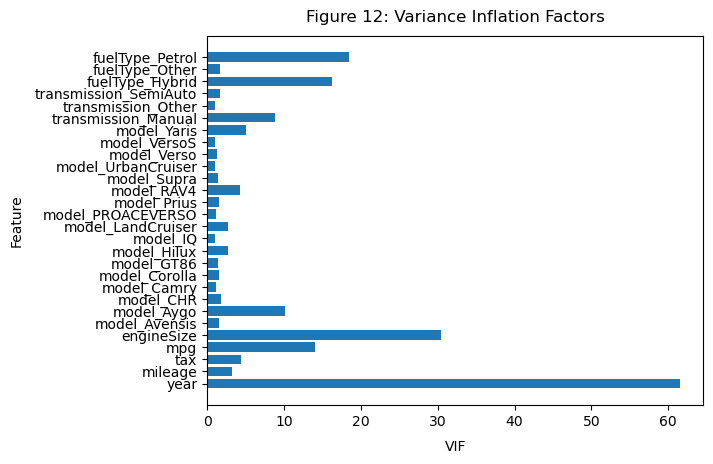

In [36]:
# create VIF dataframe with a row for each feature
vif_df = pd.DataFrame() 
vif_df['feature'] = X_train_transformed_df.columns

# calculate VIF for each feature
vif_df['VIF'] = [variance_inflation_factor(X_train_transformed_df.values, i) for i in range(len(X_train_transformed_df.columns))] 

# generate bar plot of VIF values
plt.barh(vif_df['feature'], vif_df['VIF'])
plt.title('Figure 12: Variance Inflation Factors', pad=10.0)
plt.xlabel('VIF', labelpad=8.0)
plt.ylabel('Feature', labelpad=8.0)
plt.show()

## 4.3 Model Fitting: Spot-Check Multiple Algorithms

To identify two top-performing regression algorithms, the training data and 10-fold cross validation were used to train and evaluate five models that used linear regression (LR), k-nearest neighbors (KNN), support vector machines (SVM), random forest (RF), and adaboost (AB). Each model was trained using default hyperparameters. The two models with the lowest root-mean-squared error (RMSE) were KNN and random forest (Figure 13). Therefore, these models were chosen for further evaluation.

Median RMSE (IQR):
LR: 1756.41 (185.79)
KNN: 1486.63 (212.75)
SVM: 6275.32 (387.76)
RF: 1210.69 (256.44)
AB: 2768.23 (61.71)


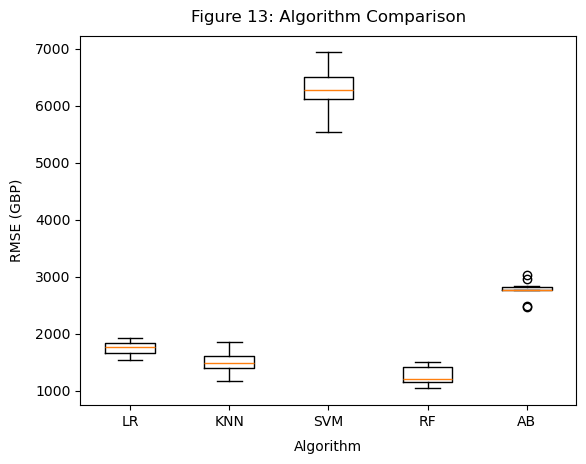

In [37]:
# prepare models to spot-check
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVM', SVR()))
models.append(('RF', RandomForestRegressor(random_state=1)))
models.append(('AB', AdaBoostRegressor(random_state=1)))

# empty lists to store cross-validation results and model names
results = []
names = []

print('Median RMSE (IQR):')

# evaluate one model at a time
for name, model in models:
    # create a pipeline with col_transformer and model
    model = make_pipeline(col_transformer, model)
    # define the cross-validation with 10 splits
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    # run 10-fold cross validation.
    # for each of the 10 runs, apply the transforms to the training folds before model training.
    # then, train the model and quantify MSE on the test fold.
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    # append RMSE to results list
    results.append(np.abs(cv_results))
    # append model name to names list
    names.append(name)
    # display model name: median RMSE (IQR)
    print('{}: {} ({})'.format(name, np.round(np.abs(np.median(cv_results)),2), np.round(iqr(cv_results),2)))
    
# generate boxplot of RMSEs for each model
plt.boxplot(results, labels=names)
plt.title('Figure 13: Algorithm Comparison', pad=10.0)
plt.xlabel('Algorithm', labelpad=8.0)
plt.ylabel('RMSE (GBP)', labelpad=8.0)
plt.show()

## 4.4 Model Fitting: Baseline and Comparison Models

Based on the results of the spot-check assessment, KNN and random forest were chosen to constitute the baseline and comparison models, respectively. KNN is a popular and relatively simple algorithm that assigns a prediction to a data point by interpolating the values of its closest n neighbors in the feature space. Therefore, the number of neighbors ('n_neighbors') hyperparameter is important to optimize. Another important hyperparameter is 'metric': the metric used to identify the closest neighbors.

Random forest is another popular algorithm that uses an ensemble of decision tree base estimators, with each decision tree trained on a different bootstrap sample of the data and, optionally, a random subset of features. With this approach, random forest is known as a robust algorithm. Compared to KNN, random forest is more complex and slower. Key hyperparameters to optimize include the number of decision trees in the forest ('n_estimators'), as well as the maximum number of features that each tree uses ('max_features').

Hyperparameter tuning was performed on the baseline (KNN) and comparison (random forest) models using grid search with 10-fold cross-validation. For KNN, 5 neighbors and the 'manhattan' distance metric were the most optimal of the tested values. For random forest, 100 estimators and all features were the most optimal of the tested values. These values and the entire training dataset were used to train final models.

In [38]:
# create a knn model object
model = KNeighborsRegressor()

# create a pipeline with col_transformer and the model
pipeline = Pipeline(steps=[('ct', col_transformer), ('model', model)])

# define parameter grid of values to test
param_grid = {'model__n_neighbors': [1,5,10,15,20],
              'model__metric':['euclidean', 'manhattan', 'minkowski']}

# create a cross-validation object with 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# create a GridSearchCV object
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='neg_root_mean_squared_error', verbose=1)

# fit GridSearchCV object to training data.
# there will be 10 runs per combination of parameter values.
# for each of the 10 runs, apply the transforms to the training folds before model training.
# then, train the model and quantify RMSE on the test fold.
grid.fit(X_train, y_train)

# display parameter values associated with the highest mean negative RMSE (i.e., lowest mean RMSE)
print(grid.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
{'model__metric': 'manhattan', 'model__n_neighbors': 5}


In [39]:
# create a random forest model object
model = RandomForestRegressor(random_state=1)

# create a pipeline with col_transformer and the model
pipeline = Pipeline(steps=[('ct', col_transformer), ('model', model)])

# define parameter grid of values to test
param_grid = {'model__n_estimators': [50,100],
              'model__max_features':['sqrt', None]}

# create a cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# create a GridSearchCV object
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='neg_root_mean_squared_error', verbose=1)

# fit GridSearchCV object to training data.
# there will be 10 runs per combination of parameter values.
# for each of the 10 runs, apply the transforms to the training folds before model training.
# then, train the model and quantify RMSE on the test fold.
grid.fit(X_train, y_train)

# display parameter values associated with the highest mean negative RMSE (i.e., lowest mean RMSE)
print(grid.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'model__max_features': None, 'model__n_estimators': 100}


In [40]:
# define linear regression model
knn = KNeighborsRegressor(n_neighbors=5, metric='manhattan')

# fit model to training data
knn.fit(X_train_transformed, y_train)

KNeighborsRegressor(metric='manhattan')

In [41]:
# define random forest model
rf = RandomForestRegressor(random_state=1, n_estimators=100, max_features=None)

# fit model to training data
rf.fit(X_train_transformed, y_train)

RandomForestRegressor(max_features=None, random_state=1)

# 5. Model Evaluation

Root-mean-squared error (RMSE) and R<sup>2</sup> were used to assess the performance of the baseline and comparison models. RMSE was chosen because, unlike mean absolute error, it gives a relatively high weight to large errors. It is appropriate to penalize larger errors more than smaller errors in this context. Large overestimation of car prices could lead to a lack of consumer interest and even a perception that Discount Motors is price-gouging, while large underestimations could result in significant revenue loss. The other evaluation metric, R<sup>2</sup> or the coefficient of determination, quantifies the proportion of the target variable's (price) variance that is explained by the model’s independent variables (features). R<sup>2</sup> is a useful statistic for evaluating the overall effectiveness and explanatory power of a regression model.

Table 2 shows the RMSE and R<sup>2</sup> for each model. The random forest model had a lower RMSE than the KNN model. Its value of 1210.38 indicates that, on average, the model’s predictions are approximately 1210.38 GBP away from the true car prices when larger errors are weighted more heavily. The R<sup>2</sup> value for the random forest model was higher by only 0.005. An R<sup>2</sup> of 0.96 indicates that the model can explain approximately 96% of the variance in car prices.

In [42]:
# use knn model to predict car prices
y_pred_knn = knn.predict(X_test_transformed)

# calculate rmse of knn model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)

# calculate r2 of knn model
r2_knn = r2_score(y_test, y_pred_knn)

# use rf model to predict car prices
y_pred_rf = rf.predict(X_test_transformed)

# calculate rmse of rf model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

# calculate r2 of rf model
r2_rf = r2_score(y_test, y_pred_rf)

Table 2: Model evaluation results.

In [43]:
# create a table to summarize evaluation results
results = pd.DataFrame({'Model':['KNN','Random forest'],
                        'RMSE':[rmse_knn, rmse_rf],
                        'R\u00b2':[r2_knn, r2_rf]})

# display table
results

,Model,RMSE,R²
0,KNN,1298.541,0.957
1,Random forest,1210.384,0.962


# 6. Key Performance Indicator

Discount Motors needs to know the error of the model in terms of the percentage of the actual car price. The goal is to estimate car prices within 10% of their actual prices. While RMSE is a common metric for evaluating regression models, it does not provide this information and therefore cannot serve as a key performance indicator (KPI). A new metric to monitor needs to be designed.

The recommended KPI is called Percent of Predictions within 10 Percent (PP10P). PP10P describes the percent of predicted prices that were within 10% of actual prices. Figure 14 displays the PP10P for each model (74% for KNN and 78% for random forest).

In [44]:
# create an independent copy of y_test to serve as a prediction error dataframe
pred_errors = y_test.copy()

# create new columns containing car prices predicted by knn and rf models
pred_errors['pred_knn'] = y_pred_knn
pred_errors['pred_rf'] = y_pred_rf

# calculate the error of each prediction
pred_errors['error_knn'] = pred_errors['pred_knn'] - pred_errors['price']
pred_errors['error_rf'] = pred_errors['pred_rf'] - pred_errors['price']

# calculate the error of each prediction as a percent of the actual price
pred_errors['percent_error_knn'] = np.round((pred_errors['error_knn'] / pred_errors['price'])*100, 2)
pred_errors['percent_error_rf'] = np.round((pred_errors['error_rf'] / pred_errors['price'])*100, 2)

# calculate the percent of predictions within 10% of actual prices
pp10p_knn = round(((pred_errors['percent_error_knn'] >= -10) & (pred_errors['percent_error_knn'] <= 10)).sum() / len(pred_errors) * 100, 2)
pp10p_rf = round(((pred_errors['percent_error_rf'] >= -10) & (pred_errors['percent_error_rf'] <= 10)).sum() / len(pred_errors) * 100, 2)

# preview pred_errors to confirm calculations
display(pred_errors.head())

# display pp10p of each model
print(f'KNN PP10P: {pp10p_knn:.2f}\nRandom forest PP10P: {pp10p_rf:.2f}')

,price,pred_knn,pred_rf,error_knn,error_rf,percent_error_knn,percent_error_rf
2201,10498,11190.6,10419.53,692.6,-78.47,6.60,-0.75
4394,7999,8067.6,8133.55,68.6,134.55,0.86,1.68
5665,17295,18186.8,17658.53,891.8,363.53,5.16,2.10
5601,9795,8703.2,7722.77,-1091.8,-2072.23,-11.15,-21.16
694,9939,10925.8,10358.96,986.8,419.96,9.93,4.23


KNN PP10P: 74.40
Random forest PP10P: 77.69


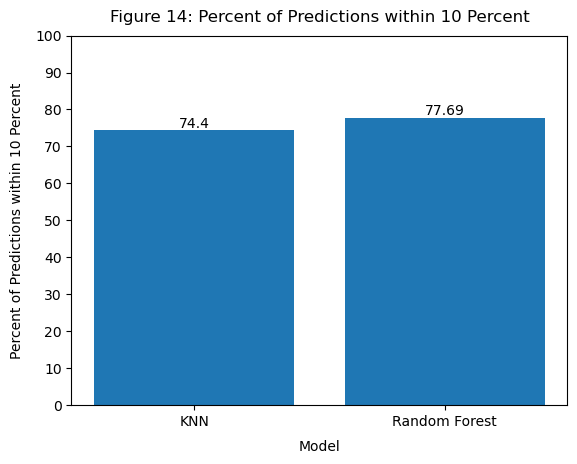

In [45]:
# generate bar plot: pp10p of each model
bar = plt.bar(['KNN', 'Random Forest'], [pp10p_knn, pp10p_rf])
plt.title('Figure 14: Percent of Predictions within 10 Percent', pad=10.0)
plt.xlabel('Model', labelpad=8.0)
plt.ylabel('Percent of Predictions within 10 Percent', labelpad=8.0)
plt.yticks(np.arange(0,110,10))
plt.bar_label(bar)
plt.show()

In addition to the PP10P metric, it is important to understand the distribution of errors for each model. Table 2 and Figure 15 show descriptive statistics and a boxplot, respectively, of the percent errors of each model's predictions. Percent error refers to the error of a predicted price as a percentage of the actual price. A negative value represents an underestimate by the model, whereas a positive value denotes an overestimate by the model.

Table 3: Descriptive statistics of the percent errors of each model's predictions.

In [46]:
# generate descriptive statistics of percent error of each model's predictions
display(pred_errors[['percent_error_knn', 'percent_error_rf']].describe().round(2))

,percent_error_knn,percent_error_rf
count,1340.00,1340.00
mean,1.21,0.09
std,13.88,10.59
min,-46.70,-47.03
25%,-5.04,-5.14
50%,-0.10,-0.26
75%,5.88,4.74
max,217.58,114.28


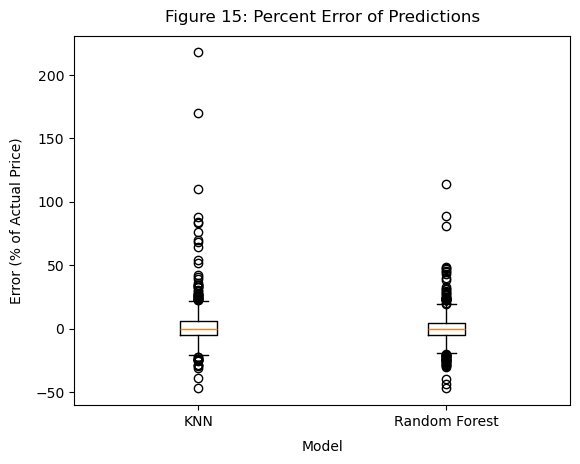

In [47]:
# generate boxplot: percent error of each model's predictions
plt.boxplot([pred_errors['percent_error_knn'], pred_errors['percent_error_rf']], labels=['KNN', 'Random Forest'])
plt.title('Figure 15: Percent Error of Predictions', pad=10.0)
plt.xlabel('Model', labelpad=8.0)
plt.ylabel('Error (% of Actual Price)', labelpad=8.0)
plt.show()

Table 3 shows that the KNN model made predictions that underestimated the price of cars by as much as 47% and overestimated prices by as much as 218%. The random forest model's largest underestimation was the same as KNN's (47%), but its largest overestimation was lower (114%) (Table 3). Overall, the range of percent errors was lower for the random forest model, indicating more stability in its predictions than KNN.

Based on the PP10P KPI and range of percent errors for each model, the random forest model is recommended for this application and dataset over the KNN model. Discount Motors will need to decide the threshold value for the PP10P metric that indicates acceptable model performance. Once this threshold is set, the random forest model and all future models can be evaluated based on whether they are expected to meet Discount Motors' business goal.

# 7. Summary and Recommendations

In summary, Discount Motors will soon be losing its car-pricing expert to retirement. An automated system would benefit the organization in terms of efficiency and sales, as manual estimates made by the team are about 30% off. The goals of this analysis were to train and evaluate models that predict car prices. Ideally, the model should estimate car prices within 10% of actual prices.

It is recommended that Discount Motors moves forward with additional testing and development of the random forest model. Random forest performed better than k-nearest neighbors (KNN) based on its lower RMSE (1210.38 GBP). Furthermore, the percent of its predicted prices that were within 10 percent of actual prices (PP10P) was higher (i.e., 78% versus 74%). The PP10P is the KPI that Discount Motors should continue to monitor. It is recommended that Discount Motors determines the threshold value for the PP10P metric that indicates acceptable model performance.

The distribution of percent errors will be important to monitor. Overall, the random forest model had a lower range of percent errors, demonstrating more stability in its predictions than KNN. However, its predictions underestimated and overestimated prices by as much as 47% and 114% percent, respectively. The cars associated with the highest errors should be investigated to determine if there are patterns. For example, perhaps cars of an uncommon model or engine size are associated with high errors. This type of investigation could reveal suitable and unsuitable applications of the predictive model.

More cars should be added to the dataset as they become available. Furthermore, data recency is especially critical in this context. Car prices are influenced by economic (e.g., inflation) and regulatory (e.g., zero emissions) conditions. Ongoing data collection and modeling will be necessary. On a regular basis, new data should be collected and incorporated into model training and evaluation.

Future work should also include testing of additional regression algorithms. It is possible that another algorithm will perform better than random forest on this application and dataset. Further optimization can be conducted with techniques such as feature engineering, feature selection, and additional hyperparameter tuning. PP10P, as well as the distribution of percent errors, should be monitored throughout the model development process.